# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)  

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [3]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

for classi : Statistic = 0.9620845913887024 and p_value = 1.1963419588312263e-08
for classj : Statistic = 0.9585496783256531 and p_value = 3.4568339302154527e-09
for classx : Statistic = 0.8562769889831543 and p_value = 1.0516706065598658e-18
classi does not look Gaussian (reject H0)
classj does not look Gaussian (reject H0)
classx does not look Gaussian (reject H0)
None of the covariances matrices are equal


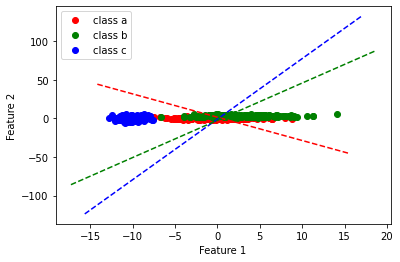

In [47]:
# Add your implementation and discussion
#Library import
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from scipy.stats import shapiro

# total numebr of point : 

ntot = a.shape[0] + b.shape[0] + c.shape[0]
#Function calculating all the necessary parameter from the classes : 

def classe_parameter(classi,ntot):
    """
    Function that calculate the mean, the variance and covariance Matrix and the prior probability of class i 
    
    Input variables : 
        classi [numpy array] : data points belonging to a specific class
        ntot [integer] : Total number of data points (from every class)
    
    output variables : 
        mean [float] : mean of the class
        covariance [float] : Covariance of the class
        p_class [float] : prior probability of the class 
    """
    mean = np.mean(classi)
    covariance = np.cov(classi)
    p_class = classi.shape[0]/ntot
    
    return (mean),covariance,p_class

def hypothesis_checking(classi,classj,classx,covariancei,covariancej,covariancex): 
    ##test if data follow a normal distribution : 
    stati, pi = shapiro(classi)
    statj, pj = shapiro(classj)
    statx, px = shapiro(classx)
    print("for {} : Statistic = {} and p_value = {}".format("classi",stati,pi))
    print("for {} : Statistic = {} and p_value = {}".format("classj",statj,pj))
    print("for {} : Statistic = {} and p_value = {}".format("classx",statx,px))
    alpha = 0.05
    if pi > alpha:
        print('{} looks Gaussian (fail to reject H0)'.format("classi"))
    else:
        print('{} does not look Gaussian (reject H0)'.format("classi"))
    
    if pj > alpha:
        print('{} looks Gaussian (fail to reject H0)'.format("classj"))
    else:
        print('{} does not look Gaussian (reject H0)'.format("classj"))
    
    if px > alpha:
        print('{} looks Gaussian (fail to reject H0)'.format("classx"))
    else:
        print('{} does not look Gaussian (reject H0)'.format("classx"))
        
     ##Determine if covariance matrices of each class are equal and if they are diagonal :
    if (np.array_equal(covariancei,covariancej)) and (np.array_equal(covariancei,covariancex)) and (np.array_equal(covariancej,covariancex)):
        if (np.count_nonzero(covariancei - np.diag(np.diagonal(covariancei))) == 0) : 
            print("Covariance matrices of each class are diagonal ")
        else :
            print("Covariance matrices of each class are equal")
    else : 
        print("None of the covariances matrices are equal")

##The previous function prooved that the only rational assumption possible is Normality 


def discriminant_function_class(classi,classj,meani,meanj,covariancei,covariancej,p_classi,p_classj):
    """
    Function that :
        1) Verify which discriminant curve separate best the 2 classes
        2) return the parameter describing the curve
    
    Input Variables : 
        classi [numpy array] : data points belonging to class i
        classj [numpy array] : data points belonging to class j
        meani [float] : mean of class i
        meanj [float] : mean of class j
        covariancei [numpy array] : Covariance matrix of class i
        covariancej [numpy array] : Covariance matrix of class j
        p_classi [float] : prior probability of the class i
        p_classj [float] : prior probability of the class j
        
    Important note : For the sake of the classifier, we assume equal covariance matrices, Normality
    
    Output variables : 
        g [numpy array] : discriminant function between class i and class j
        w [float] : slope of the line 
        x0 [float] : intercept of the discriminant line
    """
    var_classi = covariancei[0,0]
    w = meani-meanj
    x0 = 0.5*(meani+meanj)-var_classi*np.log(p_classi/p_classj)*(meani-meanj)/(np.linalg.norm(meani-meanj))
    g = (w)*(classi[:,0]-x0)
    return w,x0,g

mean_a,covariance_a,p_a = classe_parameter(a,ntot)
mean_b,covariance_b,p_b = classe_parameter(b,ntot)
mean_c,covariance_c,p_c = classe_parameter(c,ntot)
hypothesis_checking(a,b,c,covariance_a,covariance_b,covariance_c)
wab,x0ab,gab = discriminant_function_class(a,b,mean_a,mean_b,covariance_a,covariance_b,p_a,p_b)
wcb,x0cb,gcb = discriminant_function_class(b,c,mean_b,mean_c,covariance_b,covariance_c,p_b,p_c)
wac,x0ac,gac = discriminant_function_class(a,c,mean_a,mean_c,covariance_a,covariance_c,p_a,p_c)
#plot of the data : 

def abline_function(slope,intercept,color):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color)

plt.plot(a[:,0],a[:,1],'ro',b[:,0],b[:,1],'go',c[:,0],c[:,1],'bo')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(["class a","class b","class c"])
abline_function(wab,x0ab,"r--")
abline_function(wcb,x0cb,"b--")
abline_function(wac,x0ac,"g--")
plt.show()

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [ ]:
# Add your implementation and discussion

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
# Add your implementation and discussion